# Модель сегментации объектов ландшафта на данных АФС

## Содержание
* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Выбор гиперпараметров](#Выбор-гиперпараметров)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Скорость работы](#Скорость-работы)
* [Критика](#Критика)
* [Краткое резюме](#Краткое-резюме)
* [Предложения по улучшению и развитию модели](#Предложения-по-улучшению-и-развитию-модели)

## Постановка задачи

## Датасет

In [2]:
import sys
sys.path.append('../')

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import batchflow as bf

from batchflow import F,V,B,C,R
from batchflow import FilesIndex, Dataset
from batchflow.models.tf import UNet
from batchflow.research import Research, Results, Option
from batchflow.models.tf.losses import softmax_cross_entropy, dice

from aerial_batch import AerialBatch, get_origs

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
ind = FilesIndex(path='../ignore/deepglobe/train/*.jpg')
ads = Dataset(ind, AerialBatch)
ads.split(0.8, shuffle=False)

In [4]:
# Another representation 
# 0 Unknown
# 1 Water
# 2 Forest land
# 3 Urban land
# 5 Rangeland
# 6 Agriculture land
# 7 Barren land

def make_mask(mask):
    """
    """
    mask = np.squeeze(mask, -1)
    mask[mask > 2] = 0
    new_mask = np.zeros((*mask.shape, 3))
    new_mask[:,:,0] = mask==0
    new_mask[:,:,1] = mask==1
    new_mask[:,:,2] = mask==2
    return new_mask.astype(np.uint8)

## Архитектура

Используется модель UNet, реализованная в библиотеке ```batchflow.models.tf```.

Общее описание архитектуры модели доступно по ссылке [https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html)

Выбранная конфигурация модели:
##################################

Определение функции потерь:

In [8]:
def loss(labels, logits, alpha=1, beta=0.5, *args, **kwargs):

    bce_loss = alpha * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))
    dice_loss = beta * dice(labels, logits, loss_collection=None)
    loss = bce_loss + dice_loss
    tf.losses.add_loss(loss)
    
    return loss

Задание конфигурации модели:

In [9]:
model_config = {
    'initial_block/inputs': 'images',
    'inputs': dict(images={'shape': (256,256,3)}, 
                   masks={'name':'targets',
                          'shape': (256,256,3)}),
    'filters': [64, 128, 256, 512],
    'head/num_classes': 3,
    'loss': loss,
    'optimizer': 'Adam',
    'output': ['proba', 'class']
}

## Обучение

Обучение проиcходит итерациями по батчам. Итерации состоит из:
* генерации очередной порции данных
* обновления весов нейронной сети.

Для обучения выбран оптимизатор Adam со стандартными параметрами:
* ```learning_rate``` = 0.001
* ```beta1``` = 0.9
* ```beta2``` = 0.999
* ```epsilon``` = 1e-08.

Функция потерь - cross-entropy.

Схема обхода датасета:
* ```batch_size``` = 20
* количество итераций = 300.

In [10]:
batch_size = 2
n_epochs = 100
crop_shape = (256, 256)

Описание пайплайна обучения:

In [12]:
train_template = (
    bf.Pipeline()
      .load(ind, fmt='image', components='images')
      .load(ind, fmt='mask', components='masks')
      .rotate(R('randint', 0, 180), src=['images', 'masks'], dst=['images', 'masks'], p=0.5)
      .flip('lr', src=['images', 'masks'], dst=['images', 'masks'], p=0.5)
      .resize(size=(1224, 1224), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(get_origs, crop_shape, 1., src='masks', dst='origs')
      .crop(shape=crop_shape, src=('images', 'origs'), dst='images')
      .crop(shape=crop_shape, src=('masks', 'origs'), dst='masks')
#       .crop('random', shape=crop_shape, src=['images', 'masks'], dst=['images', 'masks'])
      .to_array(src='images', dst='images')
      .to_array(src='masks', dst='masks')
      .apply_transform(make_mask, src='masks', dst='masks')
      .init_variable('loss', init_on_each_run=list)
      .init_model('dynamic', UNet, 'unet', model_config)
      .train_model('unet', images=B('images'), targets=B('masks'),
                      fetches='loss', save_to=V('loss'), mode='a')
).run(batch_size, shuffle=True, lazy=True)

Запуск обучения  с размером батча 2:

In [13]:
train_pipeline = (train_template << ads.train)

In [14]:
train_pipeline.run(batch_size, n_epochs=n_epochs, bar=True)

100%|█████████▉| 32099/32100 [6:26:11<00:00,  1.45it/s]


График функции потерь в зависимости от числа итераций:

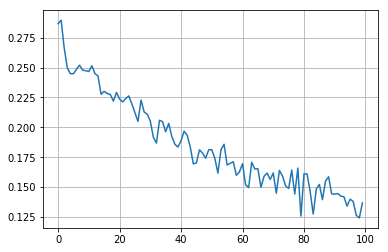

In [15]:
l = np.split(np.array(train_pipeline.get_variable('loss')), n_epochs)
plt.plot(np.array(l).mean(-1))
plt.grid(True)

In [16]:
MODEL_PATH = '../ignore/models/3c_2041120319'
train_pipeline.save_model('unet', path=MODEL_PATH)

## Оценка модели

Качество модели определяется средним значением метрики IOU (intersection over union) по выборке из 1000 картинок.

Описание процедуры расчета метрики:

In [55]:
load_model_config = {
    'build': False,
    'load': {'path': MODEL_PATH}
}

In [58]:
test_template = (
    bf.Pipeline()
      .load(ind, fmt='image', components='images')
      .load(ind, fmt='mask', components='masks')
#     .augmentations!
#      .resize(size=(1224, 1224), src=['images'], dst=['images'])
#      .resize(size=(1224, 1224), src=['masks'], dst=['masks'])
      .apply_transform(get_origs, crop_shape, 1.0, src='masks', dst='origs')
      .crop(shape=crop_shape, src=('images', 'origs'), dst='images')
      .crop(shape=crop_shape, src=('masks', 'origs'), dst='masks')
#       .crop('random', shape=crop_shape, src=['images', 'masks'], dst=['images', 'masks'])
      .to_array(src='images', dst='images')
      .to_array(src='masks', dst='masks')
      .apply_transform(make_mask, src='masks', dst='masks')
      .init_variable('batch_predictions', init_on_each_run=list)
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .init_variable('images', init_on_each_run=list)
      .init_variable('masks', init_on_each_run=list)
      .init_model('static', UNet, 'unet', config=load_model_config)
#       .import_model('unet', train_pipeline)
      .predict_model('unet', images=B('images'), targets=B('masks'),
                   fetches=['proba'], save_to=[V('batch_predictions')], mode='w')
      .gather_metrics('segmentation', targets=B('masks'), predictions=V('batch_predictions'),
                      fmt='proba', save_to=V('metrics'), mode='u')
      .update_variable('images', B('images'), mode='e')
      .update_variable('masks', B('masks'), mode='e')
      .update_variable('predictions', V('batch_predictions'), mode='e')
).run(batch_size, n_epochs=1, lazy=True)

INFO:tensorflow:Restoring parameters from ../ignore/models/3c_2041120319/model-32100


Запуск расчета метрики

In [59]:
test_pipeline = ((test_template << ads.test).run(batch_size, shuffle=False, 
                                                 n_epochs=1, drop_last=False, bar=True))



  0%|          | 0/81 [00:00<?, ?it/s]

  2%|▏         | 2/81 [00:00<00:19,  4.05it/s]

  4%|▎         | 3/81 [00:00<00:23,  3.38it/s]

  5%|▍         | 4/81 [00:01<00:24,  3.10it/s]

  6%|▌         | 5/81 [00:01<00:26,  2.89it/s]

  7%|▋         | 6/81 [00:02<00:26,  2.80it/s]

  9%|▊         | 7/81 [00:02<00:28,  2.61it/s]

 10%|▉         | 8/81 [00:02<00:28,  2.57it/s]

 11%|█         | 9/81 [00:03<00:28,  2.52it/s]

 12%|█▏        | 10/81 [00:03<00:28,  2.51it/s]

 14%|█▎        | 11/81 [00:04<00:27,  2.54it/s]

 15%|█▍        | 12/81 [00:04<00:27,  2.52it/s]

 16%|█▌        | 13/81 [00:04<00:27,  2.48it/s]

 17%|█▋        | 14/81 [00:05<00:26,  2.50it/s]

 19%|█▊        | 15/81 [00:05<00:26,  2.52it/s]

 20%|█▉        | 16/81 [00:06<00:26,  2.49it/s]

 21%|██        | 17/81 [00:06<00:25,  2.52it/s]

 22%|██▏       | 18/81 [00:06<00:24,  2.54it/s]

 23%|██▎       | 19/81 [00:07<00:24,  2.51it/s]

 25%|██▍       | 20/81 [00:07<00:24,  2.50it/s]

 26%|██▌       | 21/81 [00:08<00:23

In [60]:
metrics = test_pipeline.get_variable('metrics')
print("IOU: %.3f" % metrics.evaluate('iou', agg='mean'))
print("Confusion matrix:\n {}".format(metrics._confusion_matrix.sum(axis=0)))

IOU: 0.792
Confusion matrix:
 [[19389827  1730667]
 [ 1712765  8820629]]


Пример исходного изображения и предсказанной сегментации

In [61]:
y_pred = test_pipeline.get_variable('predictions')
images = test_pipeline.get_variable('images')
masks = test_pipeline.get_variable('masks')

Text(0.5,1,'Forest')

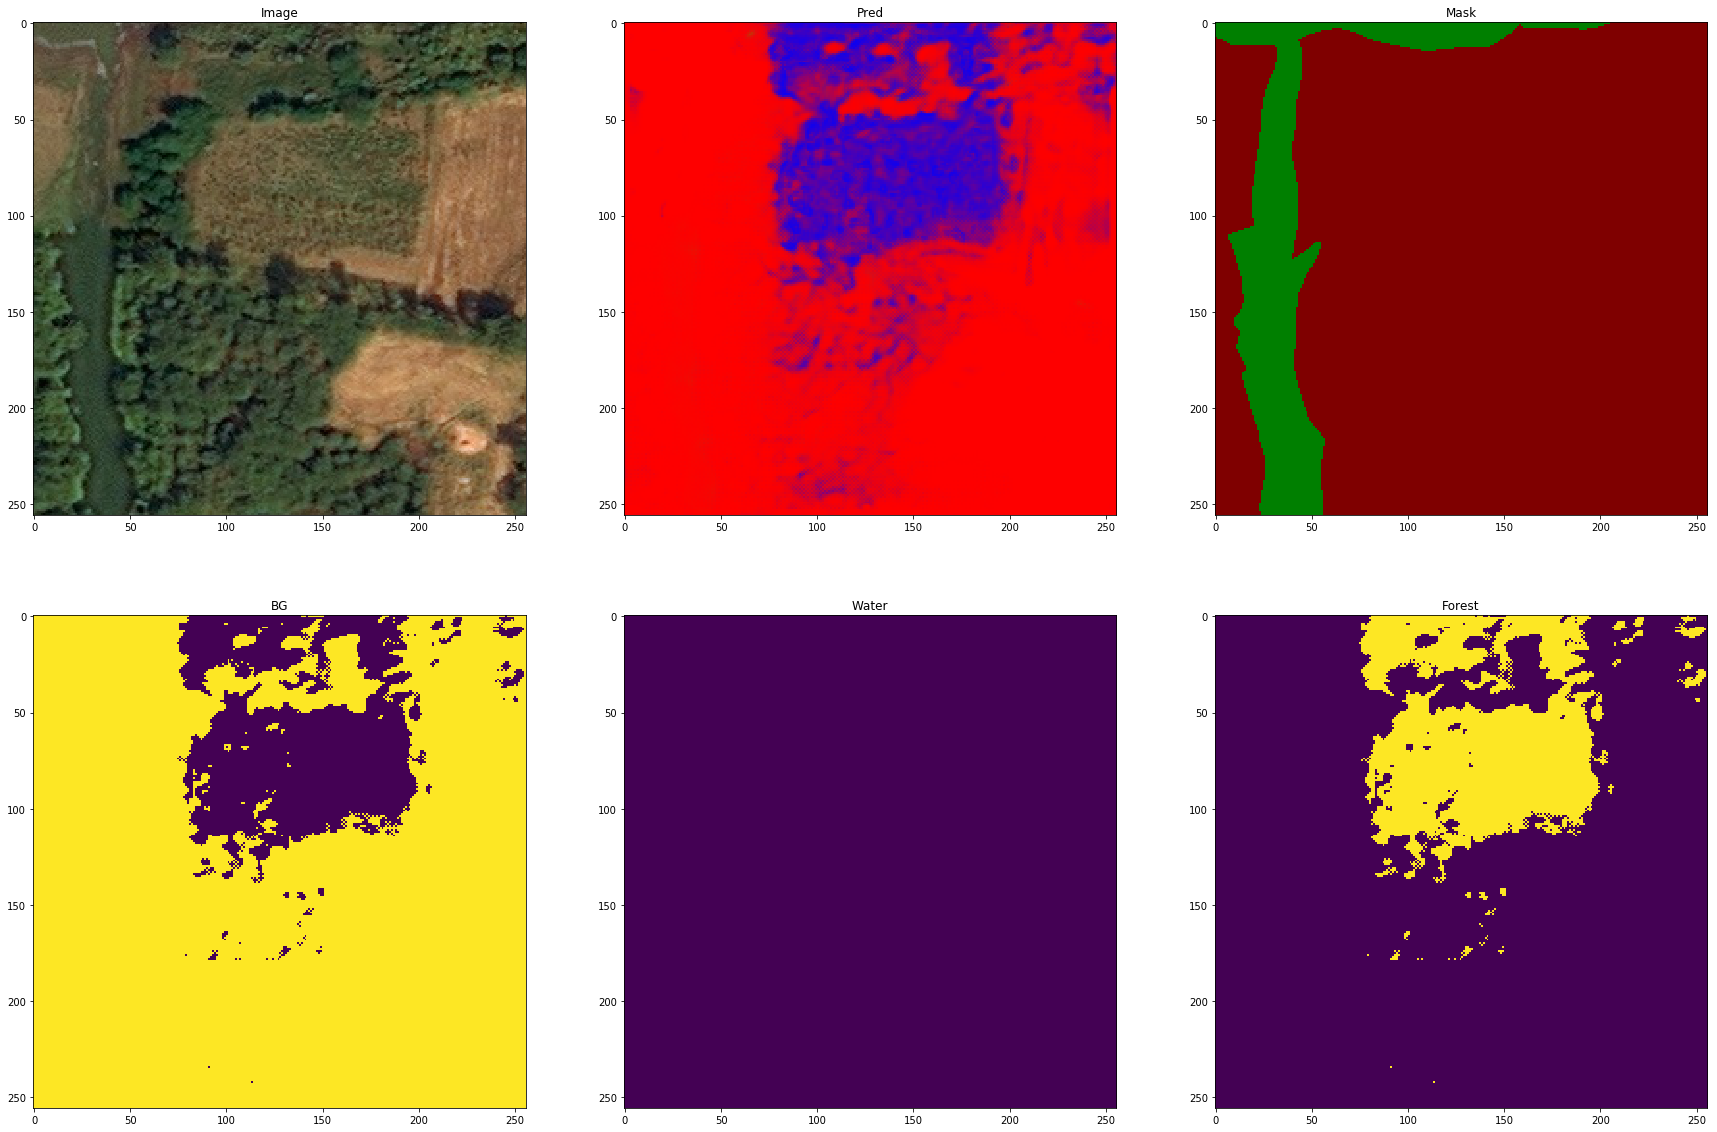

In [96]:
i = np.random.randint(len(masks))

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 20))
ax1.imshow(images[i])
ax1.set_title('Image')
ax2.imshow(y_pred[i])
ax2.set_title('Pred')
ax3.imshow(masks[i]*127)
ax3.set_title('Mask')
ax4.imshow(y_pred[i][:,:,0]>0.5)
ax4.set_title('BG')
ax5.imshow(y_pred[i][:,:,1]>0.5)
ax5.set_title('Water')
ax6.imshow(y_pred[i][:,:,2]>0.5)
ax6.set_title('Forest')

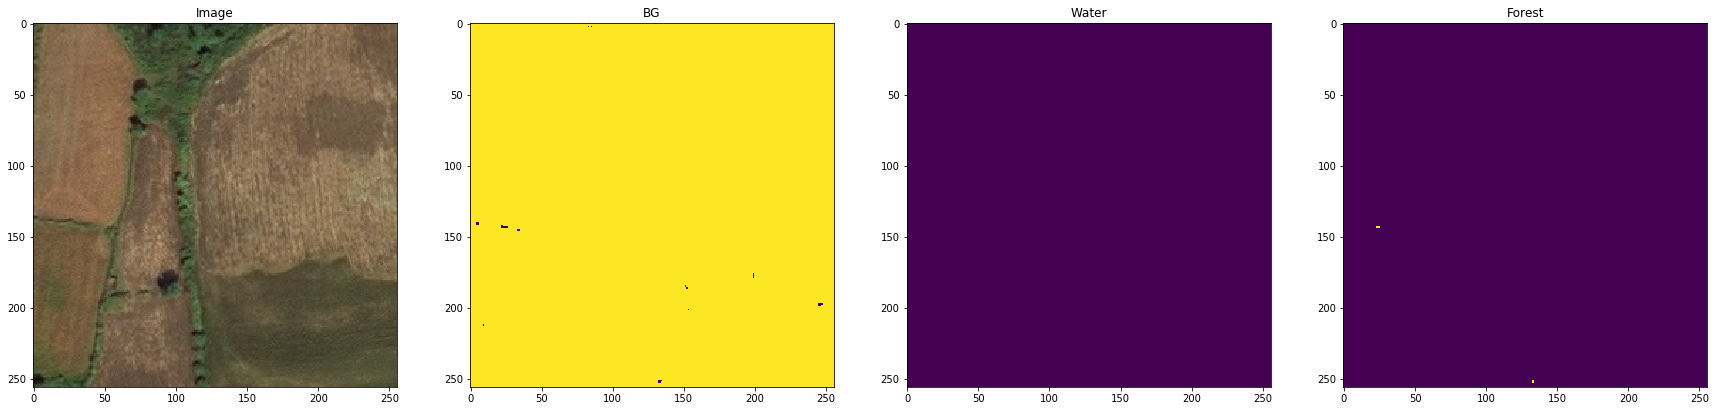

In [21]:
# i = np.random.randint(len(masks))

f, ((ax1, ax4, ax5, ax6)) = plt.subplots(1, 4, figsize=(30, 20))
ax1.imshow(images[i])
ax1.set_title('Image')
ax4.imshow(y_pred[i][:,:,0]>0.9)
ax4.set_title('BG')
ax5.imshow(y_pred[i][:,:,1]>0.1)
ax5.set_title('Water')
ax6.imshow(y_pred[i][:,:,2]>0.1)
ax6.set_title('Forest')
plt.savefig('aerial_sample_{}.png'.format(i))